This notebook sets up a method to compute filter weights.

The idea is that you have a vector of values with some grid spacing.
You want to filter to get the part of the vector that is 'resolvable' on a coarser grid, with grid spacing $x$
times bigger than the grid of the data. For example if the data is spaced 50 km and you want to filter in a way that produces something relevant to a model with 150 km grid spacing, then $x=150/50 = 3$.

The filter is a moving average: you multiply the $n$ entries above and below (or to the left and right if you prefer) the current point (and the current point) by some weights that sum to one, which gives you a weighted average at the current point; then you do this weighted average over all the points.
The weights are symmetric left and right (up and down), and the vector of weights has length $2n+1$.

The most obvious thing to do is to do a moving average with width $2x+1$ where all the weights are equal.
Another thing you could try is a Gaussian moving average.
It's not as clear how to choose the width of the Gaussian, but you might let the weights be proportional to $e^{-0.5(d/x)^2}$ where $d$ is the distance to the central point. 
You'd probably want something like $n=3x$ or $n=4x$ and then just set weights for points further away to zero.
This is OK because the weights further away, while technically not zero, would be smaller than machine precision.

Another thing you could try (which I've done here) is try to design the filter weights so that the filter is spectrally sharp: it chooses some cutoff wavelength and zeros out smaller scales while leaving larger scales unchanged.
The following code uses a coarsening factor $x$ and a filter radius $n$ (width is $2n+1$) to generate weights corresponding to a "sharp" filter.

In [1]:
import numpy as np
from scipy import interpolate
from scipy import integrate
import matplotlib.pyplot as plt
x = 2; # example coarsening factor
F = interpolate.PchipInterpolator(np.array([0,1/x,np.pi/x,np.pi]),np.array([1,1,0,0]))

The above snippet defines $F$ to be a piecewise cubic polynomial. The arguments are wavenumbers, with $\pi$ representing the Nyquist wavenumber, i.e. the smallest resolvable scale on the grid.
The values of $F$ are the values of the Fourier transform of the target/ideal filter.
Coarsening by a factor of $x$ means that wavenumbers larger than $\pi/x$ should be zeroed out.
We're tentatively saying (see Bar & Prime document) that there is a factor of 3 between the grid scale of a model and the resolvable scale, so $F$ smoothly transitions from 0 to 1 over the corresponding range of wavenumbers.
See plot below.

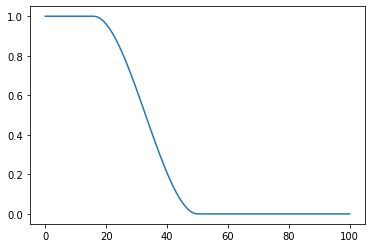

In [2]:
%matplotlib inline
plt.plot(np.array(F(np.linspace(0,np.pi,num=101))))

The next step is to generate weights that correspond (approximately) to this target/ideal filter. I won't explain the following function in this notebook.

In [4]:
def getWeights(n):
    w = np.zeros(n+1) # initialize weights
    for i in range(n):
        integrand = lambda k: 2*(F(k)-1)*(np.cos((i+1)*k)-1)
        w[i] = integrate.quad(integrand,0,np.pi)[0]
    A = 2*np.pi*(np.eye(n) + 2)
    w[1:] = np.linalg.solve(A,w[0:n])
    w[0] = 1 - 2*np.sum(w[1:])
    return w

With this function it's a good idea to make sure that you've picked a wide enough filter, i.e. a large enough $n$. To do this, first set the coarsening factor then just keep increasing $n$ until the weights stop changing. For a factor of $x=2$ you don't need a very wide filter:

In [5]:
print(getWeights(1))
print(getWeights(2))
print(getWeights(3))
print(getWeights(4))
print(getWeights(5))
print(getWeights(6))

[0.37571851 0.31214075]
[0.30754255 0.24396479 0.10226393]
[ 0.31301783  0.24944007  0.10773921 -0.0136882 ]
[ 0.32578116  0.2622034   0.12050254 -0.00092488 -0.04467163]
[ 0.33106922  0.26749146  0.1257906   0.00436318 -0.03938357 -0.02379628]
[ 0.33100344  0.26742568  0.12572483  0.00429741 -0.03944935 -0.02386205
  0.00036176]


The above example shows that a filter width of $2n+1=9$ or $11$ is probably enough to make sure that your filter corresponds to a model with grid size $2\times$ bigger than the size of your data. It's kind of surprising that it needs that much, but on the other hand in the Gaussian example if $x=2$ then we might want 4 standard deviations on either side, which comes to a width of 9 points as well.

Larger coarsening factors require wider filters.
For example, to coarsen by a factor of 8 requires at least $n=16$:

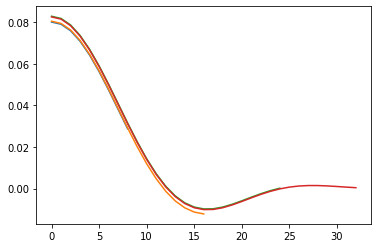

In [12]:
x = 8; # update coarsening factor
F = interpolate.PchipInterpolator(np.array([0,1/x,np.pi/x,np.pi]),np.array([1,1,0,0])) # Update target filter
plt.plot(getWeights(8))
plt.plot(getWeights(16))
plt.plot(getWeights(24))
plt.plot(getWeights(32))